In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
import re

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the Data

In [57]:
payments_url='https://www.dropbox.com/scl/fi/b22lrut0ao87fcjia4j7y/payments_data.dta?rlkey=oowaamfqrmoqauyekyk5mdyqi&st=v6cgrr7t&dl=1'
payments_df = pd.read_stata(payments_url)

In [58]:
payments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680760 entries, 0 to 680759
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   division              680760 non-null  object 
 1   districtname          680760 non-null  object 
 2   ratingarea_name       680760 non-null  object 
 3   circle_name           680760 non-null  object 
 4   pin                   680760 non-null  object 
 5   street_address        680760 non-null  object 
 6   total_property_tax    680760 non-null  float32
 7   payable_property_tax  680760 non-null  float64
 8   exempted_amount       680760 non-null  float64
 9   remission             680760 non-null  int32  
 10  netdemand             680760 non-null  float64
 11  year                  680760 non-null  object 
 12  totalrecovery         680760 non-null  float32
 13  bank_code             680760 non-null  object 
 14  receipttype           680760 non-null  object 
 15  

### Check for missing or invalid values

In [59]:
print(payments_df.isna().sum())
print(payments_df.isin(['NA', 'N/A', '','na', 'null', 'NULL','missing']).sum())
# no null values found

division                0
districtname            0
ratingarea_name         0
circle_name             0
pin                     0
street_address          0
total_property_tax      0
payable_property_tax    0
exempted_amount         0
remission               0
netdemand               0
year                    0
totalrecovery           0
bank_code               0
receipttype             0
region                  0
payment_date            0
dtype: int64
division                0
districtname            0
ratingarea_name         0
circle_name             0
pin                     0
street_address          0
total_property_tax      0
payable_property_tax    0
exempted_amount         0
remission               0
netdemand               0
year                    0
totalrecovery           0
bank_code               0
receipttype             0
region                  0
payment_date            0
dtype: int64


### Checking for negative values

In [60]:
float_cols = payments_df.select_dtypes(include=['float32', 'float64']).columns
(payments_df[float_cols] < 0).any()

,0
total_property_tax,False
payable_property_tax,False
exempted_amount,False
netdemand,False
totalrecovery,True


In [61]:
# FIX NO. 1: One negative value found in 'totalrecovery' column. Replaced with 0
neg_recovery = payments_df[payments_df['totalrecovery'] < 0]
print(neg_recovery[['division', 'districtname','total_property_tax','payable_property_tax','exempted_amount', 'totalrecovery', 'payment_date']].head())
payments_df['totalrecovery'] = payments_df['totalrecovery'].clip(lower=0)

       division districtname  total_property_tax  payable_property_tax  \
644720   Lahore       Lahore         6800.640137               6800.64   

        exempted_amount  totalrecovery payment_date  
644720              0.0         -516.0   2023-03-31  


### Formatting string values

In [62]:
str_cols = payments_df.select_dtypes(include=['object', 'string']).columns
for col in str_cols:
    payments_df[col] = (
        payments_df[col]
        .astype(str)                       # Ensure string type
        .str.strip()                       # Remove leading/trailing whitespace
        .str.replace(r'\s+', ' ', regex=True)  # Replace multiple spaces with single space
        .str.replace(r'[^\x00-\x7F]+', '', regex=True)  # Remove non-ASCII if needed
        .str.upper()                       # Convert to UPPERCASE (use .lower() if preferred)
    )
print("Cleaned text columns:", list(str_cols))

Cleaned text columns: ['division', 'districtname', 'ratingarea_name', 'circle_name', 'pin', 'street_address', 'year', 'bank_code', 'receipttype', 'region', 'payment_date']


### Drop duplicates

In [63]:
# trying candidate keys
cand_keys = [
    ['pin', 'payment_date','receipttype', 'bank_code'],
]
for keys in cand_keys:
    print(payments_df.duplicated(subset=keys).sum(), " rows found with exact dupliactes across these columns: ", keys)

before = len(payments_df)
payments_df = payments_df.drop_duplicates(keep='first')  # full-row duplicates only
after = len(payments_df)
print(f"Removed {before - after} exact duplicate rows. New shape: {payments_df.shape}")

1874  rows found with exact dupliactes across these columns:  ['pin', 'payment_date', 'receipttype', 'bank_code']
Removed 1010 exact duplicate rows. New shape: (679750, 17)


In [64]:
## Unresolved Issue 1: Multiple entries found with the same 'pin','payment_date','receipttype','bank_code'.
## Issue left unresolved due to ambuguity regarding whether this is an error or real data

# Parse Fiscal Year

In [65]:
payments_df['payment_date'] = pd.to_datetime(payments_df['payment_date'])
def get_fiscal_year(date):
    if date.month >= 7:
        return date.year + 1
    else:
        return date.year
payments_df['fiscal_year'] = payments_df['payment_date'].apply(get_fiscal_year)
# Months July and onwards are pushed to the next fiscal year

### Derived Variables

In [66]:
# Arreas_prev
payments_df['arrears_prev']=payments_df['receipttype'].apply(lambda x: 1 if x=='Combine' else 0)

# Paid_share
payments_df['paid_share'] = np.where(
    payments_df['netdemand'] > 0,
    payments_df['totalrecovery'] / payments_df['netdemand'],
    np.nan
)

# Paid_any
payments_df['paid_any']=payments_df['totalrecovery'].apply(lambda x: 1 if x>0 else 0)

## Task 2: Summary Stats

### Fiscal year 2022-2023

In [67]:
# Number of unique properties in fiscal year 2022-2023
yr = '2022-2023'
unique_properties_22_23=payments_df[payments_df['year'].astype(str).str.strip() == yr]['pin'].nunique()
print("Number of unique properties in fiscal year 2022-2023: ", unique_properties_22_23)

Number of unique properties in fiscal year 2022-2023:  317140


In [68]:
# Share paid
share_paid = payments_df.loc[payments_df['year'] == yr, 'paid_any'].mean()
print("Share of properties that paid in", yr, ": ", (share_paid.round(2)*100),"%")

# Mean paid_share
mean_paid_share = payments_df['paid_share'].mean()
print("Overall mean paid share: ",mean_paid_share.round(2))

# Mean netdemand
mean_netdemand = payments_df['netdemand'].mean()
print("Overall mean net demand of tax: ",mean_netdemand.round(2))

# Mean totalrecovery
mean_totalrecovery = payments_df['totalrecovery'].mean()
print("Overall mean total recovery of tax: ",mean_totalrecovery.round(2))

Share of properties that paid in 2022-2023 :  100.0 %
Overall mean paid share:  1.2
Overall mean net demand of tax:  21358.26
Overall mean total recovery of tax:  17768.87


### Breakdown by region

In [69]:
payments_df.groupby(['region'])[['paid_share','netdemand','totalrecovery']].mean().round(2)

,paid_share,netdemand,totalrecovery
region,,,
REGION-A,1.16,16020.19,13084.040039
REGION-B,1.23,25435.77,21347.410156


### Breakdown by circle_name

In [70]:
# For visualisation purposes, circles names have been simplified. ie, 'BAHRIA TOWN I' and 'BAHRIA TOWN II' have been
# replaced by 'BAHRIA TOWN'. This will reduce the number of unique circle names so we can try visualise the breakdown

def clean_circle_name(name):

    name = re.sub(r'[_\s-]*Z[-_\s]?\d+', '', name)
    # Remove roman numerals with separators (e.g., "-II", "_III", " II")
    name = re.sub(r'[-_\s]+[IVX]+$', '', name)
    # Remove trailing digits (e.g., "-1", "_2")
    name = re.sub(r'[-_\s]+\d+$', '', name)
    # Collapse extra spaces and underscores
    name = re.sub(r'[_\s]+', ' ', name).strip()
    return name

payments_df['circle_name_base'] = payments_df['circle_name'].apply(clean_circle_name)
print(payments_df[['circle_name','circle_name_base']].drop_duplicates().head(10))


                  circle_name        circle_name_base
0          SHALIMAR LINK ROAD      SHALIMAR LINK ROAD
58             BAGHBAN PURA-I            BAGHBAN PURA
380         DARAS BARHEY MIAN       DARAS BARHEY MIAN
496           BAGHBAN PURA-II            BAGHBAN PURA
614                GHAZI ABAD              GHAZI ABAD
3739   KOTLI PIR ABDUL REHMAN  KOTLI PIR ABDUL REHMAN
6976              G.T. ROAD-I               G.T. ROAD
8021      KOT KHAWAJA SAEED-I       KOT KHAWAJA SAEED
12665    KOT KHAWAJA SAEED-II       KOT KHAWAJA SAEED
12685             BADAMI BAGH             BADAMI BAGH


### Average Paid Share by Circle

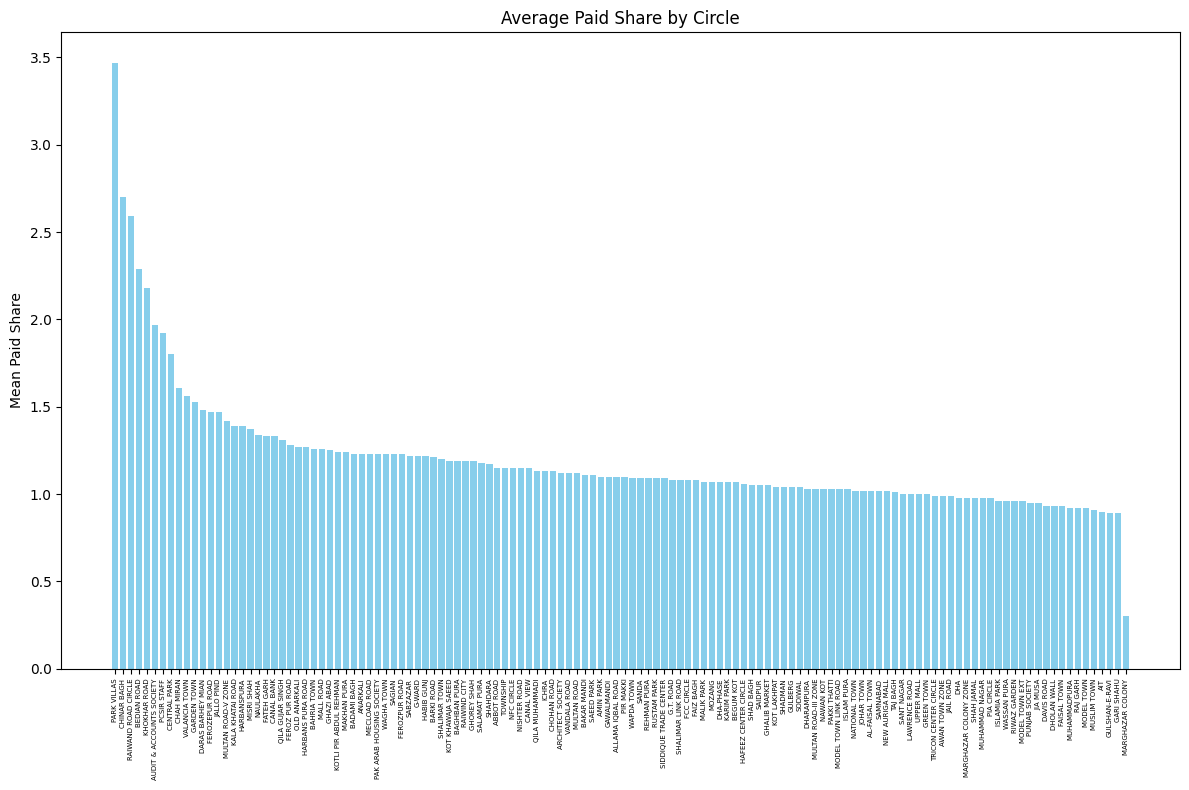

In [71]:
payments_df.groupby('circle_name')[['paid_share','netdemand','totalrecovery']].mean().round(2).reset_index()
circle_stats = (payments_df.groupby('circle_name_base')[['paid_share','netdemand','totalrecovery']].mean().round(2).reset_index())

filtered_stats = circle_stats[circle_stats['circle_name_base'].str.len() > 1]
filtered_stats = filtered_stats.sort_values('paid_share', ascending=False)

plt.figure(figsize=(12,8))
plt.bar(filtered_stats['circle_name_base'], filtered_stats['paid_share'], color='skyblue')
plt.xticks(rotation=90, fontsize=5)
plt.ylabel('Mean Paid Share')
plt.title('Average Paid Share by Circle')
plt.tight_layout()
plt.show()



### Average Net Demand by Circle

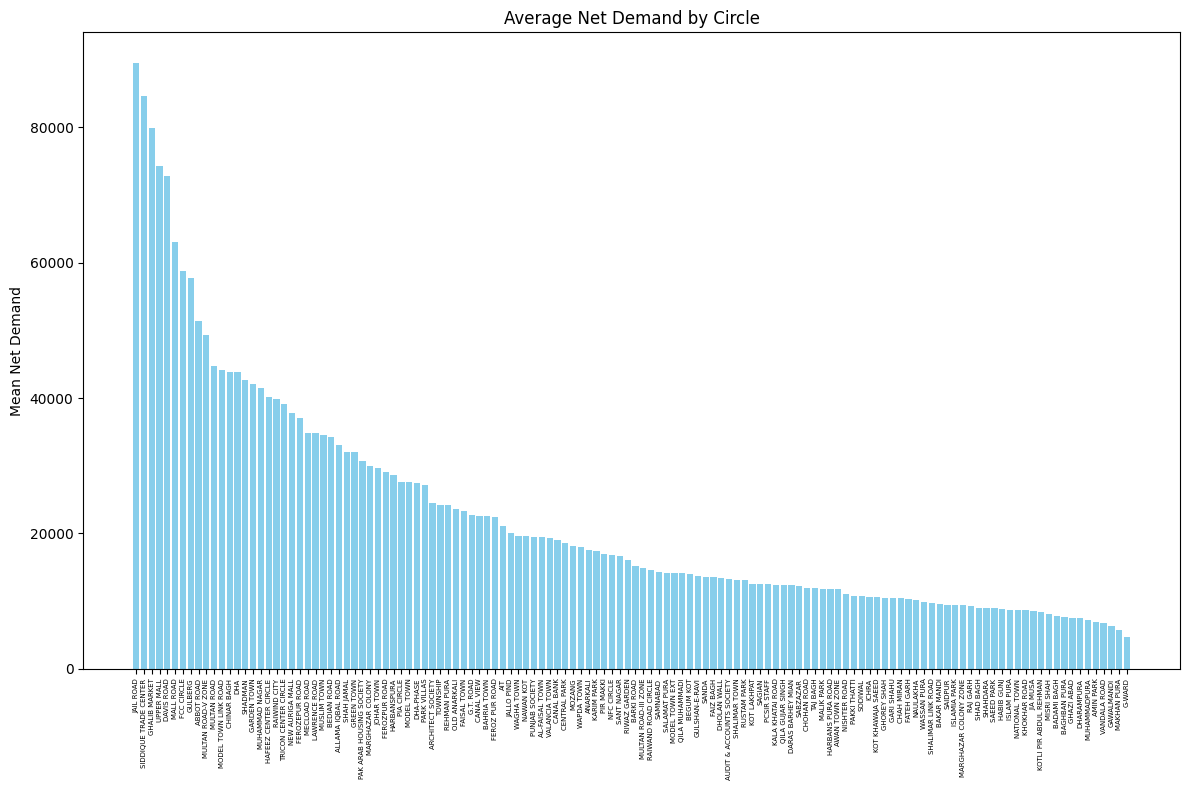

In [72]:
filtered_stats = filtered_stats.sort_values('netdemand', ascending=False)

plt.figure(figsize=(12,8))
plt.bar(filtered_stats['circle_name_base'], filtered_stats['netdemand'], color='skyblue')
plt.xticks(rotation=90, fontsize=5)
plt.ylabel('Mean Net Demand')
plt.title('Average Net Demand by Circle')
plt.tight_layout()
plt.show()

### Average Total Recovery by Circle

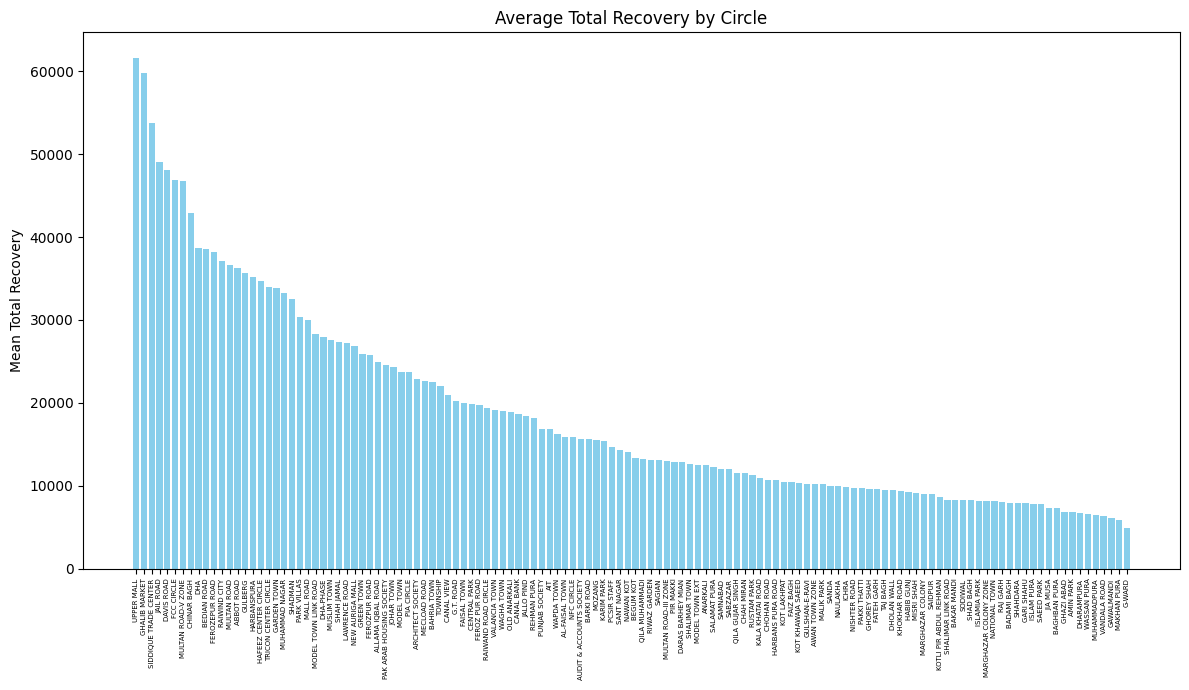

In [73]:
filtered_stats = filtered_stats.sort_values('totalrecovery', ascending=False)

plt.figure(figsize=(12,7))
plt.bar(filtered_stats['circle_name_base'], filtered_stats['totalrecovery'], color='skyblue')
plt.xticks(rotation=90, fontsize=5)
plt.ylabel('Mean Total Recovery')
plt.title('Average Total Recovery by Circle')
plt.tight_layout()
plt.show()

## Task 3 - Payment Timelines

In [74]:
# Due date = 30th sep of that year
payments_df['due_date'] = pd.to_datetime(payments_df['payment_date'].dt.year.astype(str) + '-09-30')

# Delay
payments_df['payment_delay'] = (payments_df['payment_date'] - payments_df['due_date']).dt.days

summary = payments_df['payment_delay'].describe(percentiles=[0.1, 0.5, 0.9])
print(summary[['mean', '50%', '10%', '90%']])


mean    -40.959453
50%     -12.000000
10%    -207.000000
90%      46.000000
Name: payment_delay, dtype: float64


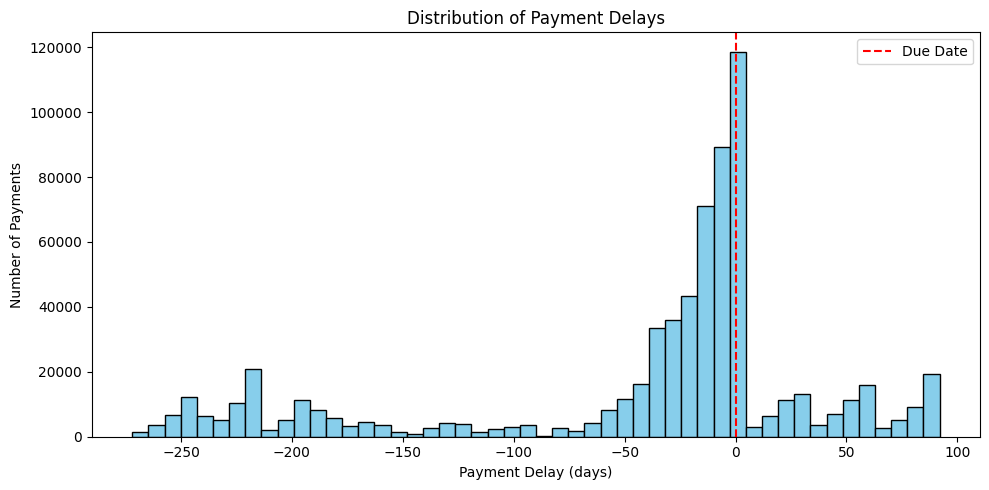

In [75]:
plt.figure(figsize=(10,5))
plt.hist(payments_df['payment_delay'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--', label='Due Date')
plt.xlabel('Payment Delay (days)')
plt.ylabel('Number of Payments')
plt.title('Distribution of Payment Delays')
plt.legend()
plt.tight_layout()
plt.show()


In [77]:
file_path = '/content/drive/MyDrive/my_payments_data.dta'
payments_df.to_stata(file_path, write_index=False)
